# Image Processing Lab04

## Setup

In [ ]:
!apt update && apt install -y ffmpeg libsm6 libxext6
!pip install tensorflow
!pip install opencv-python

Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 http://security.debian.org/debian-security buster/updates InRelease [65.4 kB]
Get:3 http://deb.debian.org/debian buster-updates InRelease [51.9 kB]
Get:4 http://security.debian.org/debian-security buster/updates/main amd64 Packages [314 kB]
Get:5 http://deb.debian.org/debian buster/main amd64 Packages [7,906 kB]
Get:6 http://deb.debian.org/debian buster-updates/main amd64 Packages [8,792 B]
Fetched 8,468 kB in 3s (3,353 kB/s)



7 packages can be upgraded. Run 'apt list --upgradable' to see them.



libsm6 is already the newest version (2:1.2.3-1).
libsm6 set to manually installed.
libxext6 is already the newest version (2:1.3.3-1+b2).
libxext6 set to manually installed.
The following additional packages will be installed:
  i965-va-driver intel-media-va-driver libaacs0 libaom0 libasound2
  libasound2-data libass9 libasyncns0 libavc1394-0 libavcodec58 libavdevice58
  libavfilter7 libavformat58 libavresample4 libavutil56

## Import

In [ ]:
import tensorflow as tf
import cv2 as cv
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

## 4.1 VGG16 Model Parameters

In [ ]:
img1 = cv.imread("dog2.jpeg")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img1 = cv.resize(img1, dsize=(224, 224))

In [ ]:
# Load VGG16 model from tensorflow.keras
model = VGG16()
# model detail
model.summary()

553467904/553467096 [==============================] - 9s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
# retrieve kernel weights from the 1st convolutional layer
kernel, biases = model.layers[1].get_weights()
print(kernel.shape)

# View CNN layer 1 architecture
model.layers[1].get_config()

(3, 3, 3, 64)


{'name': 'block1_conv1',
 'trainable': True,
 'dtype': 'float32',
 'filters': 64,
 'kernel_size': (3, 3),
 'strides': (1, 1),
 'padding': 'same',
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'groups': 1,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [ ]:
# Preprocess the image using keras and numpy
# Convert the image to an array
img = img_to_array(img1)

# expand the dimension so that it represents a single 'sample'
# reshape 3D(H, W, Ch) image to 4D image (sample, H, W, Ch)
img = expand_dims(img, axis=0)

# prepare the image (e.g. scale pixel values for the vgg)
img_ready = preprocess_input(img)

In [ ]:
# Extract Model CNN Layer1
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Extract Results from CNN Layer 1 called feature map (shape = (sample = 1, 224, 224, n_filters))
# CNN Layer 1 -> n_filters = 64
feature_maps = model.predict(img_ready)
feature_maps.shape

(1, 224, 224, 64)

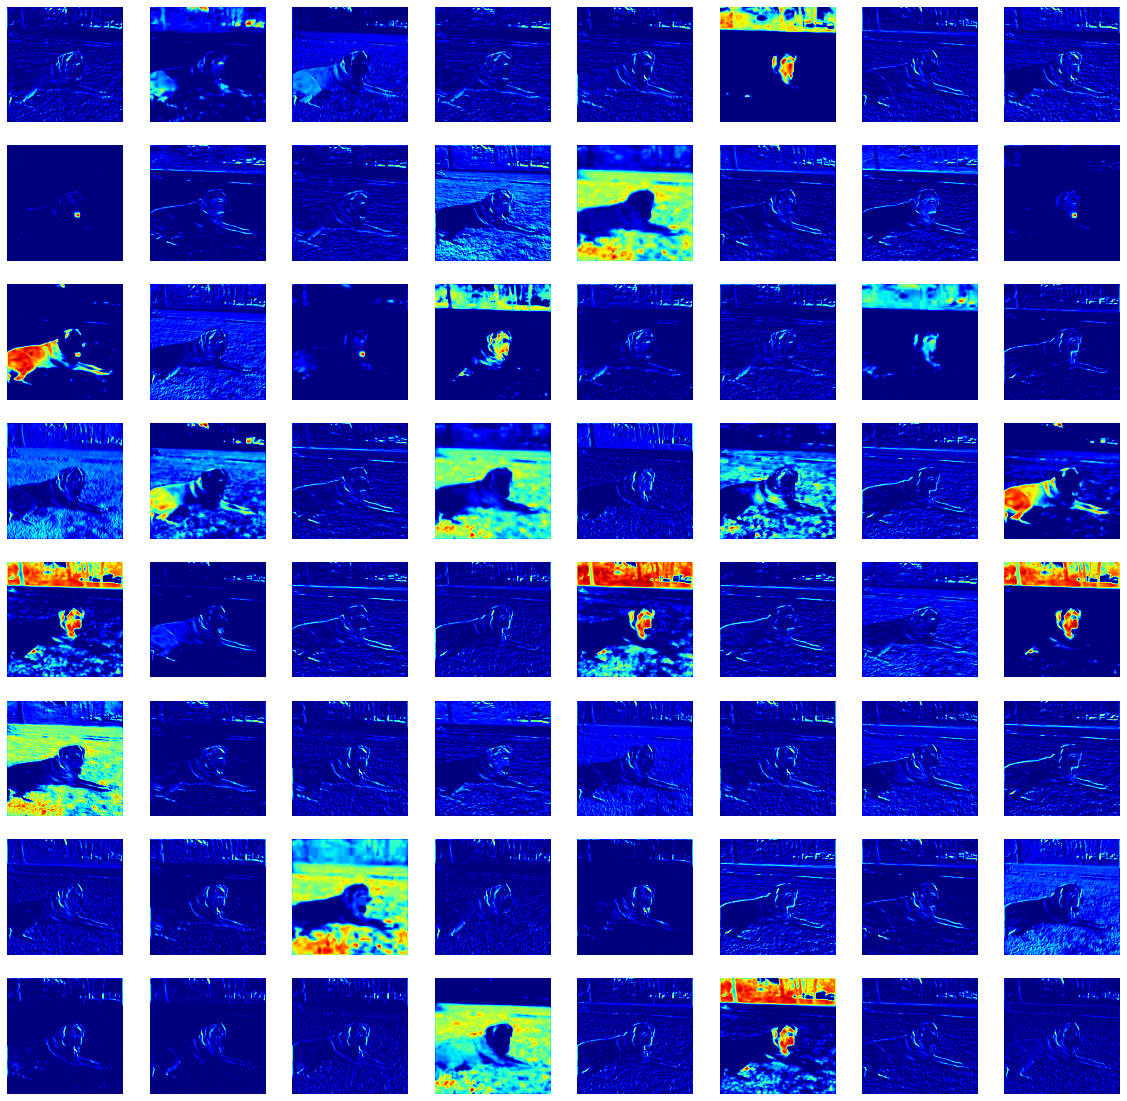

In [ ]:
# Display the image of feature_maps
fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))

map_idx = 0
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(feature_maps[0, :, :, map_idx], cmap="jet")
        map_idx += 1
        ax[i, j].axis('off')

## 4.2 Image Preparation (From Scratch)

In [ ]:
img1 = cv.imread("dog2.jpeg")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

# Image resize (H, W) -> (224, 224)
img1 = cv.resize(img1, dsize=(224, 224)).astype(np.float32)
img1.shape

(224, 224, 3)

In [ ]:
# Image subtract Dataset mean of R, G, B
img_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)

image = img1 - img_mean

# Color conversion RGB to BGR
#image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
image = image[:, :, ::-1]

# Image reshape from 3D image (H, W, Ch) -> 4D image (1, H, W, Ch)
height, width, channels = image.shape
image = image.reshape((1, height, width, channels))
image.shape

(1, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


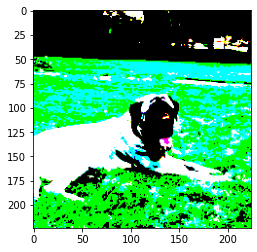

In [ ]:
plt.imshow(image[0])
plt.show()

## 4.3 Conv2D

In [ ]:
def activation(img):
    height,width = img.shape
    for i in range(height):
        for j in range(width):
            if img[i, j] < 0:
                img[i, j] = 0
    return img


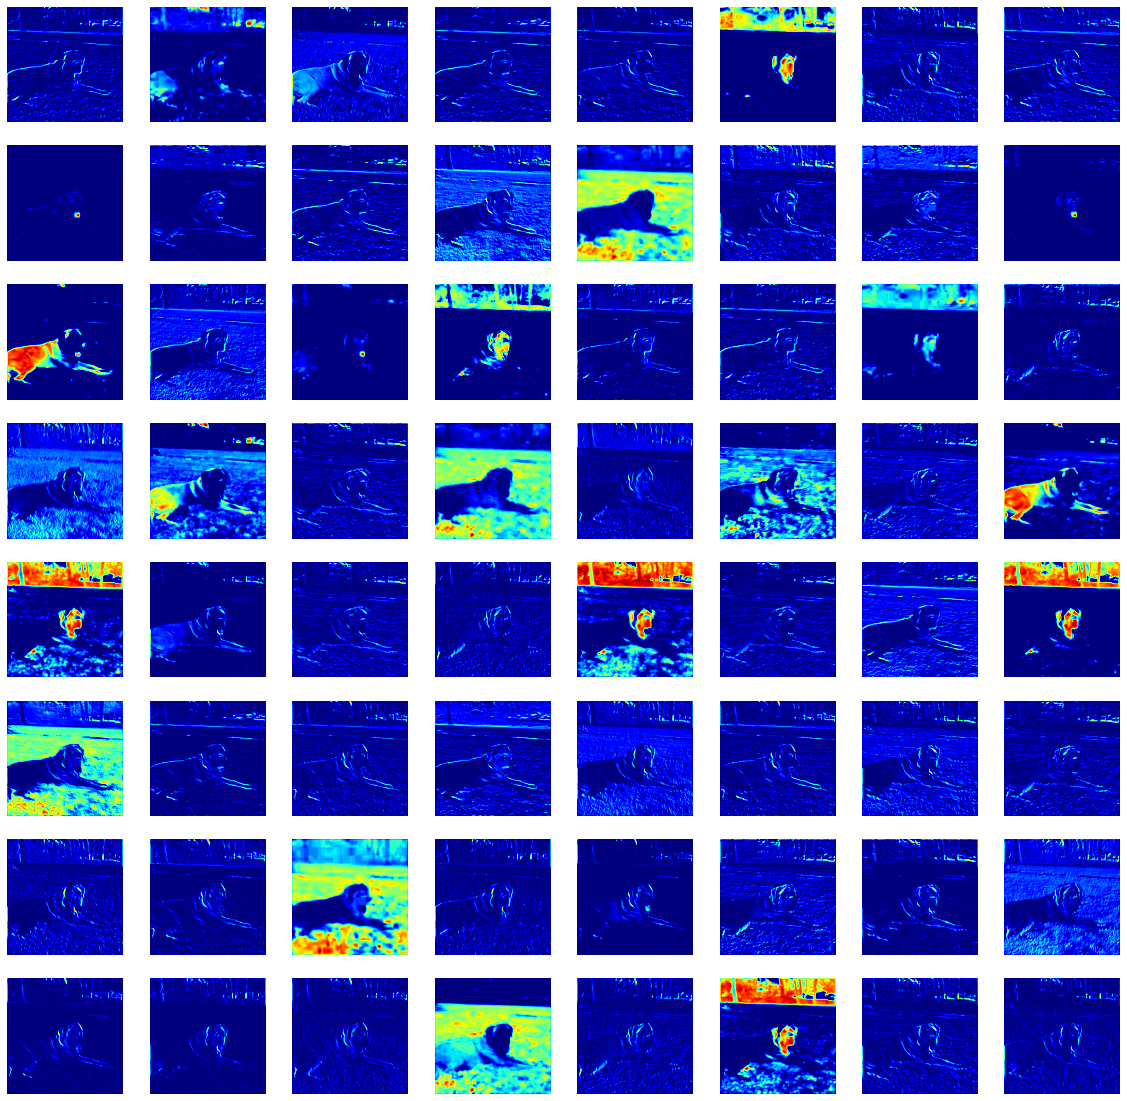

In [ ]:
# Display the image of feature_maps
fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))

img_result = np.zeros(shape=(224, 224, 3))
filter_idx = 0
for i in range(8):
    for j in range(8):
        img_result[:, :, 0] = signal.convolve2d(image[0, :, :, 0], kernel[:, :, 0, filter_idx], mode='same', boundary='fill', fillvalue=0)
        img_result[:, :, 1] = signal.convolve2d(image[0, :, :, 1], kernel[:, :, 1, filter_idx], mode='same', boundary='fill', fillvalue=0)
        img_result[:, :, 2] = signal.convolve2d(image[0, :, :, 2], kernel[:, :, 2, filter_idx], mode='same', boundary='fill', fillvalue=0)
        img_sum = img_result[:, :, 0] + img_result[:, :, 1] + img_result[:, :, 2]
        activated_img = activation(img_sum)
        ax[i, j].imshow(activated_img, cmap="jet")
        filter_idx += 1
        ax[i, j].axis('off')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a9c61174-43b4-4f44-b80d-acadc3ddea7f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>